In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torch.autograd import Variable
import torch.nn.functional as F

import gym
import cv2
import copy
from multiprocessing.pool import ThreadPool
import threading
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from rq import Queue
from redis import Redis

import random
import sys
import os
import time
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ga_model import *

def to_np(x):
    return x.data.cpu().numpy()

# Gym stuff

In [2]:
env = gym.make('FrostbiteDeterministic-v4')

[2018-03-21 00:20:40,332] Making new env: FrostbiteDeterministic-v4


Discrete(18)


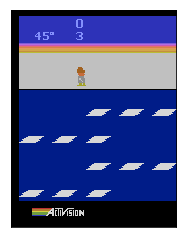

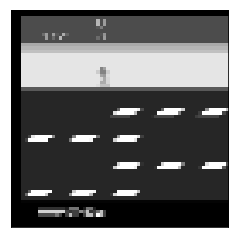

In [3]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if len(im.shape) == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def render(env, converted=False):
    state = env.render(mode='rgb_array')
    if converted:
        state = convert_state(state)
    plt.show(show_img(state))
    
reset(env)
print(env.action_space)
render(env)
render(env, converted=True)

# Model

> We use the larger DQN architecture from Mnih et al. (2015) consisting of 3 convolutional layers with 32, 64, and 64 channels followed by a hidden layer
with 512 units. The convolutional layers use 8 × 8, 4 × 4, and 3 × 3 filters with strides of 4, 2, and 1, respectively. All hidden layers were followed by a rectifier nonlinearity (ReLU). The network contains over 4M parameters.

In [4]:
states = []
for _ in range(4):
    states.append(step(env, env.action_space.sample())[0])

In [5]:
m = Model(random_state())
print('first try')
print(to_np(m(Variable(torch.Tensor([states])))))
print('didn\'t change anything, should be the same')
print(to_np(m(Variable(torch.Tensor([states])))))
m.evolve(0.005, random_state())
print('after evolution, should be different but only slightly')
print(to_np(m(Variable(torch.Tensor([states])))))

m2 = uncompress_model(m.compress())
print('copied model, should be the same')
print(to_np(m2(Variable(torch.Tensor([states])))))


first try
[[ 0.1191228  -0.8711898   0.42776275  0.19066775  0.16241857  0.8035878
  -0.61707604 -1.0426903   0.3129349   0.30215982  1.2460183  -0.80302775
  -0.6828691  -0.2374751  -0.2536229  -0.5345104  -0.8301259  -1.2509856 ]]
didn't change anything, should be the same
[[ 0.1191228  -0.8711898   0.42776275  0.19066775  0.16241857  0.8035878
  -0.61707604 -1.0426903   0.3129349   0.30215982  1.2460183  -0.80302775
  -0.6828691  -0.2374751  -0.2536229  -0.5345104  -0.8301259  -1.2509856 ]]
after evolution, should be different but only slightly
[[ 0.23844606 -0.90780354  0.6174349   0.20491223  0.18856826  1.0275394
  -0.6806948  -1.3485574   0.20656978  0.44525886  1.4826114  -1.0349385
  -0.75016254 -0.45254272 -0.12576383 -0.5637666  -0.7704897  -1.347951  ]]
copied model, should be the same
[[ 0.1191228  -0.8711898   0.42776275  0.19066775  0.16241857  0.8035878
  -0.61707604 -1.0426903   0.3129349   0.30215982  1.2460183  -0.80302775
  -0.6828691  -0.2374751  -0.2536229  -0.534

Ok great, it compiles.

# GA

In [47]:
class GA:
    def __init__(self, population, compressed_models=None, queue_name='default'):
        self.population = population
        self.models = [CompressedModel() for _ in range(population)] if compressed_models is None else compressed_models
        
        self.redis = Redis()
        self.queue = Queue(connection=self.redis, name=queue_name)
        for j in self.queue.jobs:
            j.cancel()

    def get_best_models(self, env, max_eval=20000, max_noop=30):
        jobs = []
        for m in self.models:
            jobs.append(self.queue.enqueue(evaluate_model, env, m, max_eval=max_eval, max_noop=max_noop, result_ttl=86400))
        last_enqueue_time = time.time()
        while True:
            scores = [j.result for j in jobs]
            if None not in scores:
                break
            if time.time() - last_enqueue_time > 60:
                print(f'Reenqueuing unfinished jobs ({sum(x is None for x in scores)}).')
                for i in range(len(jobs)):
                    if jobs[i].result is None:
                        jobs[i].cancel()
                        jobs[i] = self.queue.enqueue(
                            evaluate_model, env, self.models[i], max_eval=max_eval, max_noop=max_noop, result_ttl=86400)
                last_enqueue_time = time.time()
            time.sleep(1)
        scored_models = list(zip(self.models, scores))
        scored_models.sort(key=lambda x: x[1], reverse=True)
        return scored_models

    def evolve_iter(self, env, sigma=0.005, truncation=10, max_eval=20000, max_noop=30):
        scored_models = self.get_best_models(env, max_eval=max_eval, max_noop=max_noop)
        scores = [s for _, s in scored_models]
        median_score = np.median(scores)
        mean_score = np.mean(scores)
        max_score = scored_models[0][1]
        scored_models = scored_models[:truncation]
        
        # Elitism
        self.models = [scored_models[0][0]]
        for _ in range(self.population):
            self.models.append(copy.deepcopy(random.choice(scored_models)[0]))
            self.models[-1].evolve(sigma)
            
        return median_score, mean_score, max_score


In [48]:
ga = GA(100)

In [46]:
for _ in range(10):
    print(ga.evolve_iter(env.spec.id, max_eval=1000))

Reenqueuing unfinished jobs (93).
Reenqueuing unfinished jobs (85).
Reenqueuing unfinished jobs (76).


KeyboardInterrupt: 